# Basic Data Gathering

- Extracting basic dependencies between typescript modules
- Every .tsx file is taken into consideration

In [77]:
def module_name_from_file_path(full_path):


    file_name = full_path
    file_name = file_name.replace("Anytype/","")
    file_name = file_name.replace(".tsx","")
    file_name = file_name.replace(".ts","")
    file_name = file_name.replace("/",".")
    return file_name

In [78]:
import re

import_pattern = re.compile(r'import\s+(?:[\w*\s{},]*)\s+from\s+["\'](.+?)["\']')


In [79]:
import os

all_files = []

rootdir = "Anytype/"

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith('.ts') or file.endswith('.tsx'):
            all_files.append(os.path.join(subdir, file))

# Just a little test to see if it indeed captures even very nested files
assert 'Anytype/src/ts/model/content/bookmark.ts' in all_files

In [80]:
import_dict = {}

for file in all_files:
    try:
        with open(file, "r", encoding="utf-8") as f:
            content = f.read()
            all_imports = import_pattern.findall(content)
            if all_imports:
                cleaned_imports = []
                for im in all_imports:
                    if im.startswith("./"):
                        path = "/".join(file.split("/")[:-1])+(im.replace("./","/"))
                        cleaned_imports.append(module_name_from_file_path(path))
                    else:
                        cleaned_imports.append(im)
                import_dict[module_name_from_file_path(file)] = cleaned_imports
            else:
                #needed to add this otherwise it would give a key error on files with no imports
                import_dict[module_name_from_file_path(file)] = []
    except UnicodeDecodeError:
        print(f"Skipping non-text file: {file}")
    except Exception as e:
        print(f"Error processing {file}: {str(e)}")


print("\n=== bookmarks has imports Lib and mobx ===")
print(import_dict[module_name_from_file_path("src/ts/model/content/bookmark.ts")])
assert ['Lib', 'mobx'] == import_dict[module_name_from_file_path("src/ts/model/content/bookmark.ts")]


=== bookmarks has imports Lib and mobx ===
['Lib', 'mobx']


# Extract Dependencies between all files

In [81]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for file in all_files:

    module_name = module_name_from_file_path(file)

    if module_name not in G.nodes:
        G.add_node(module_name)

    for each in import_dict[module_name]:
        G.add_edge(module_name, each)

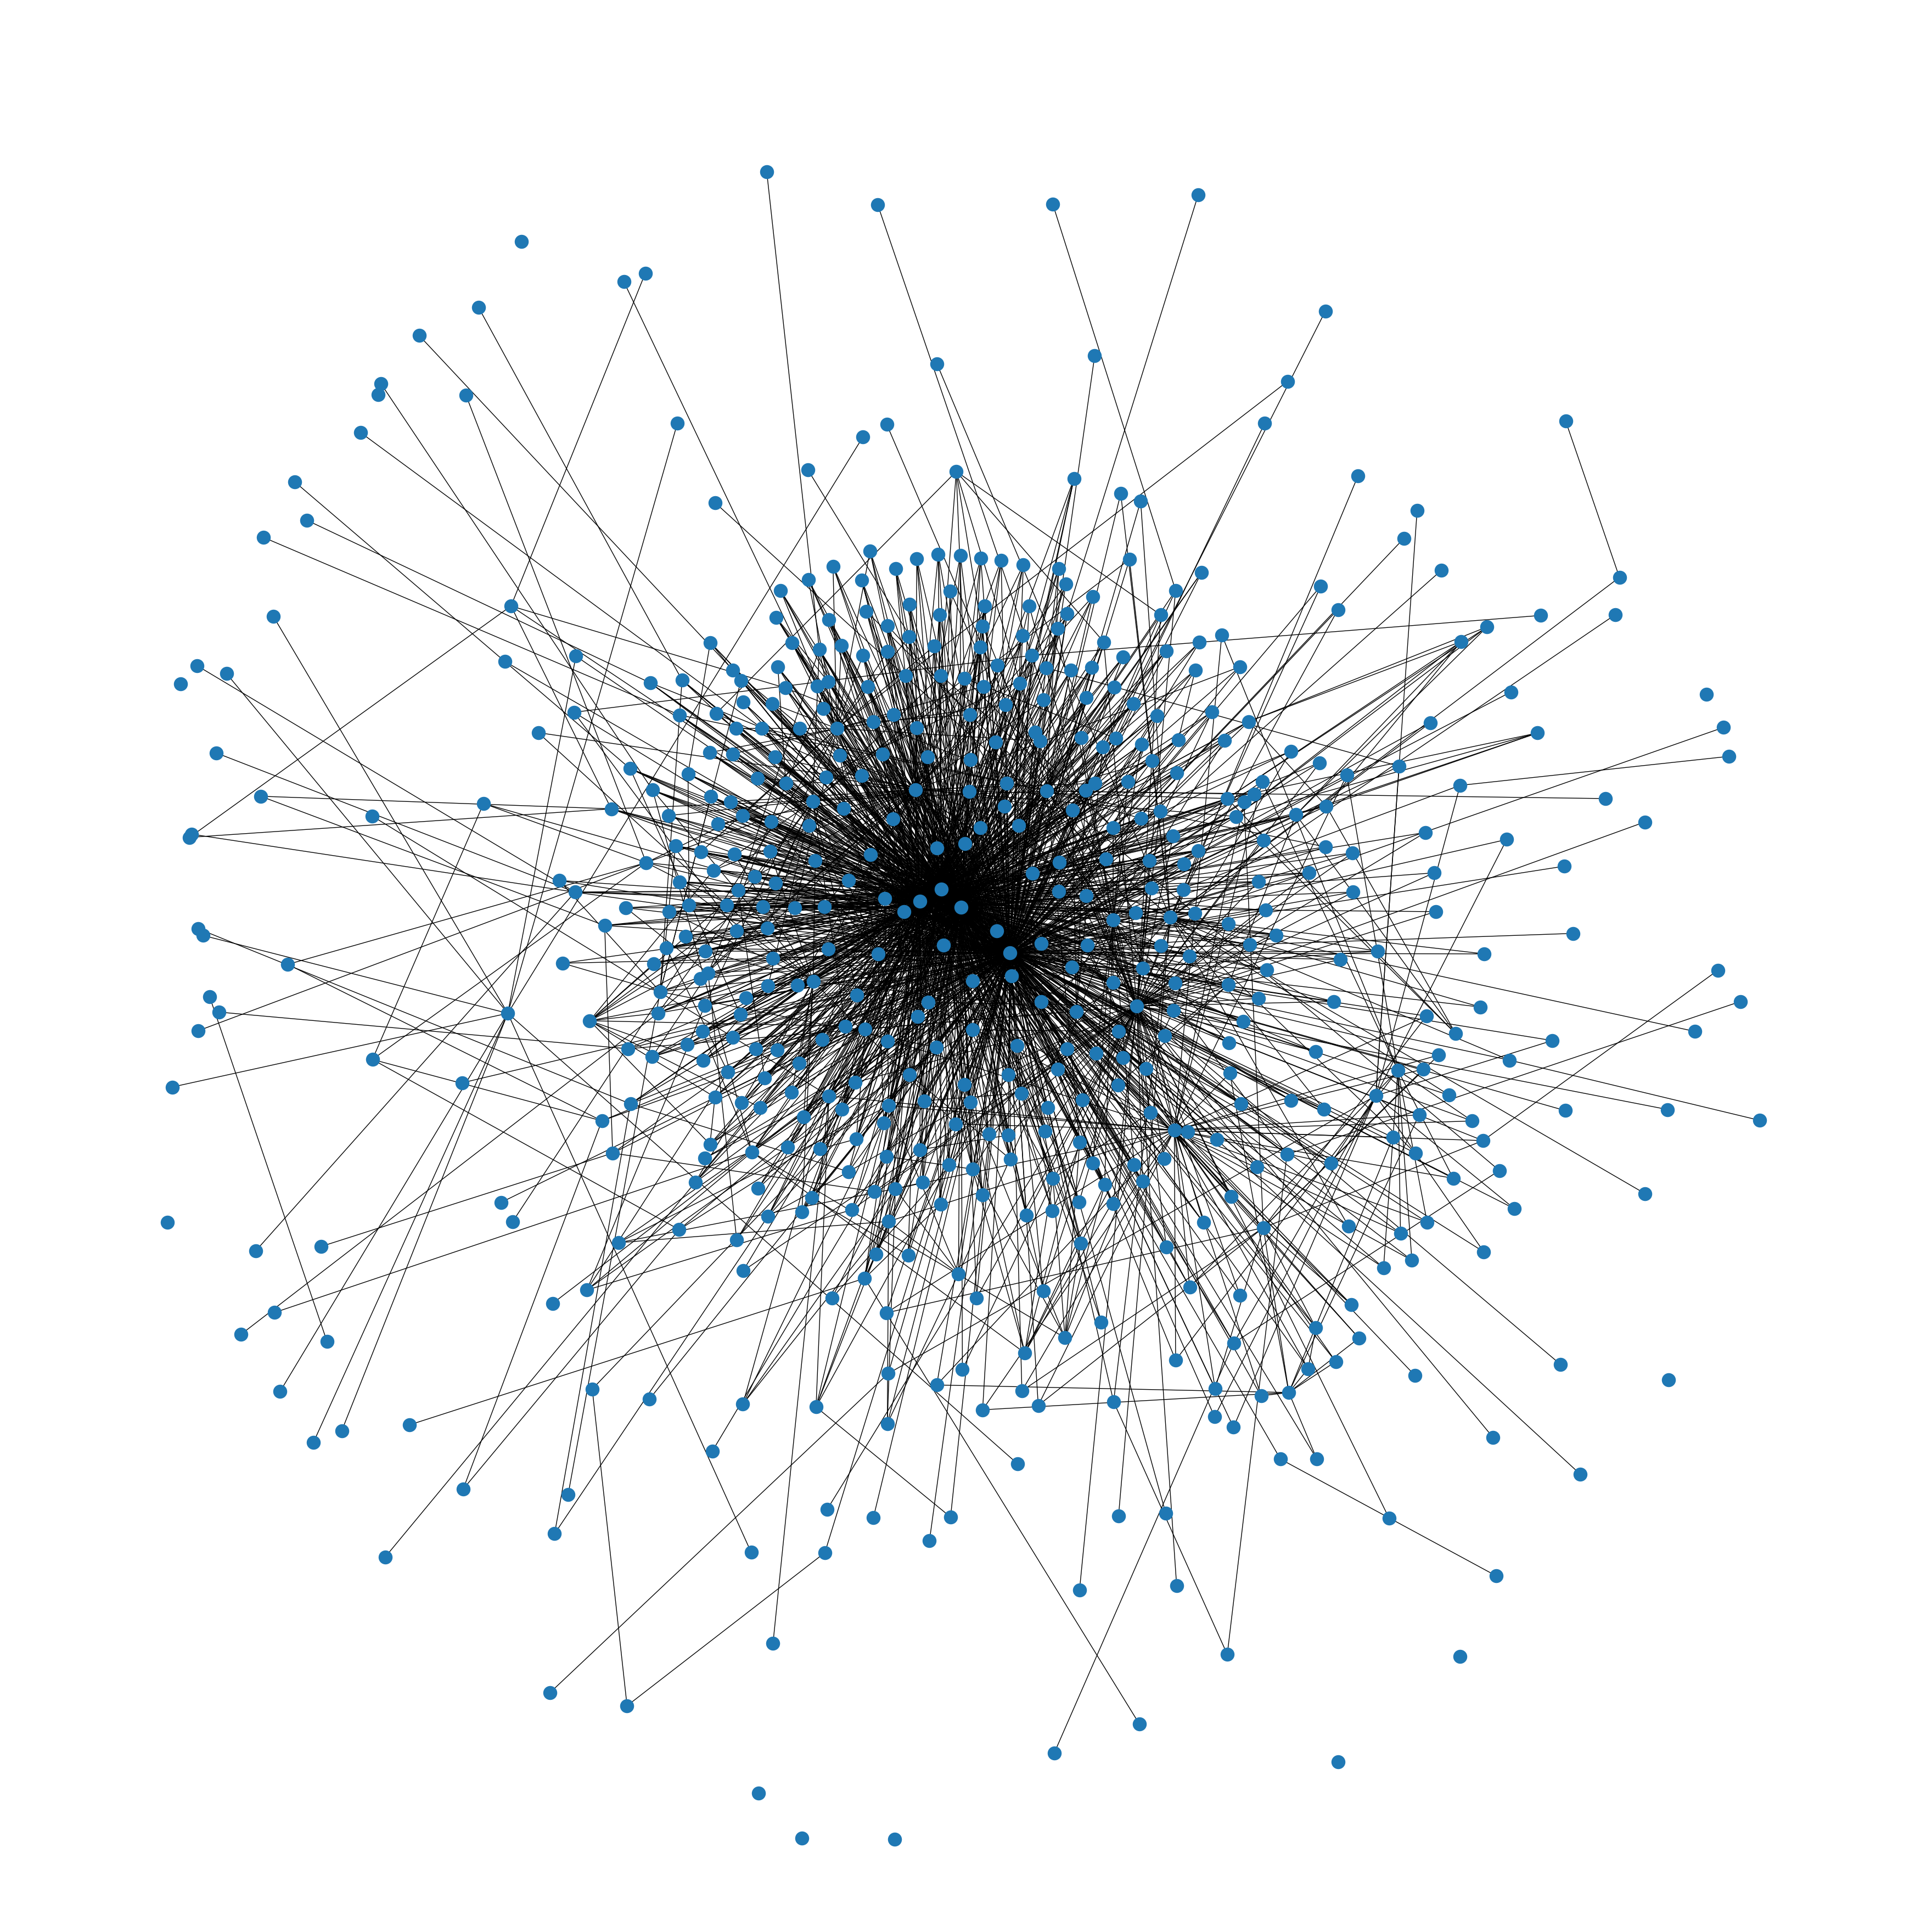

In [82]:
# a function to draw a graph
def draw_graph(G, size, **args):
    pos = nx.spring_layout(G, k=0.5, iterations=100, seed=42)

    plt.figure(figsize=size)
    nx.draw(G, pos, **args)
    plt.show()


draw_graph(G, (35,35), with_labels=False)

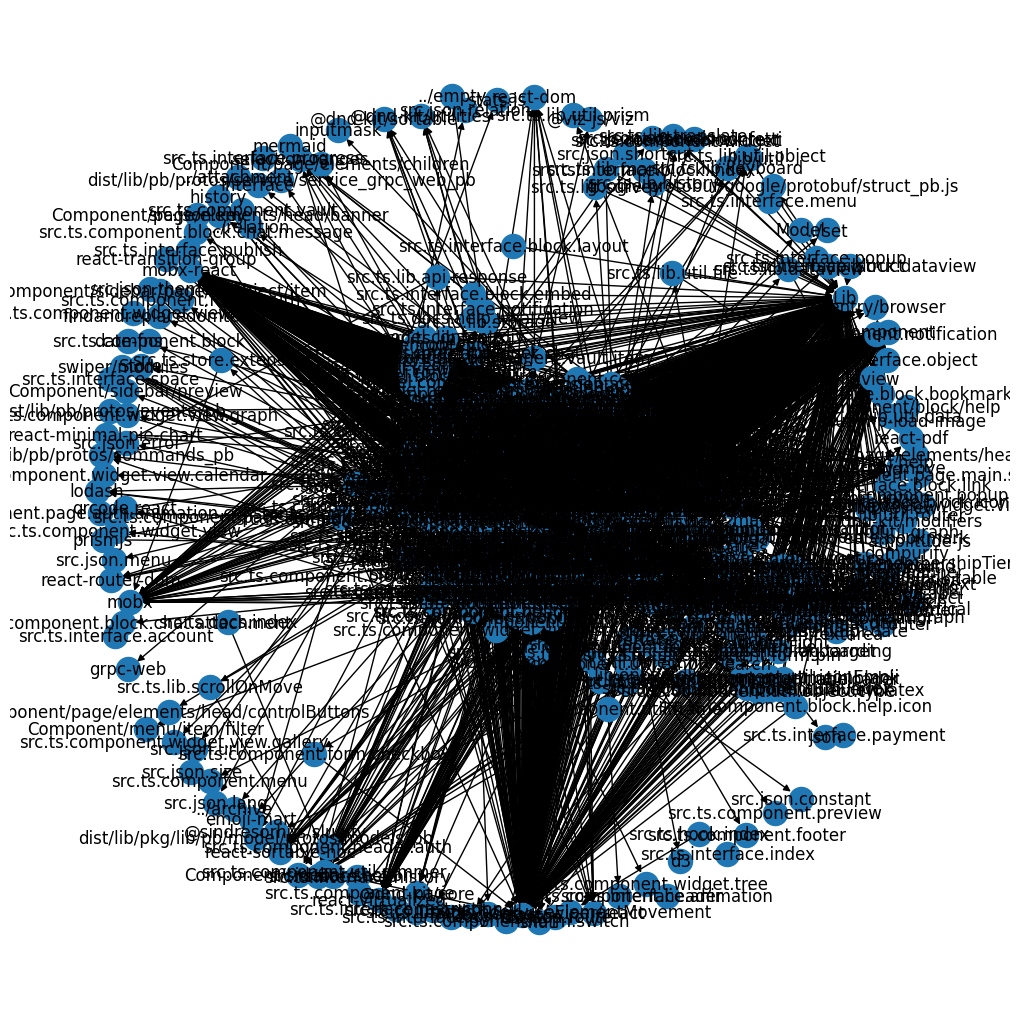

In [87]:
H = nx.DiGraph()

for file in all_files:

    source_module = module_name_from_file_path(file)

    if source_module not in H.nodes:
        H.add_node(source_module)

    for target_module in import_dict[source_module]:
        H.add_edge(source_module, target_module)


draw_graph(H, (10,10), with_labels=True)

# Abstraction Using Hierachy and Naming Conventions


In [84]:
# extracts the parent of depth X
def top_level_package(module_name, depth=1):
    components = module_name.split(".")
    return ".".join(components[:depth])


assert (top_level_package("src.model.content.table", 1) == "src")
assert (top_level_package("src.model.content.table", 2) == "src.model")

In [85]:
def abstracted_to_top_level(G, depth=1):
    aG = nx.DiGraph()
    for each in G.edges():
          src = top_level_package(each[0], depth)
          dst = top_level_package(each[1], depth)

          if src != dst and src.startswith("src") and dst.startswith("src"):
              src = src.replace("src.", "")
              dst = dst.replace("src.", "")
              aG.add_edge(src, dst)

    return aG

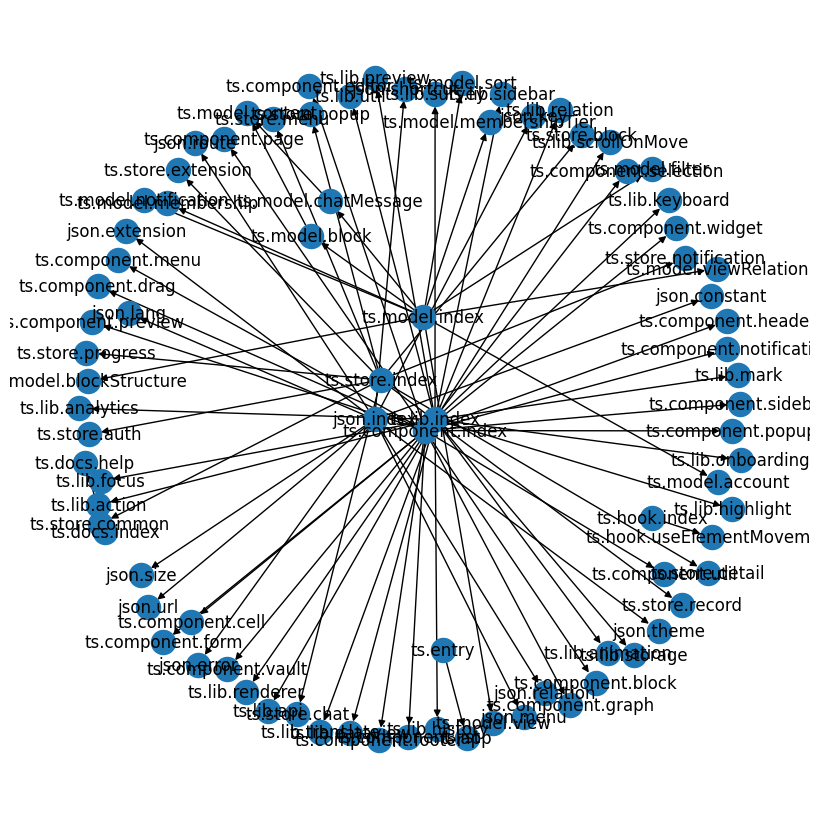

In [86]:
AH = abstracted_to_top_level(H, 4)


draw_graph(AH, (8,8), with_labels=True)


# Have identified the following interesting focalpoints
- ts.entry -> ts.app
- ts.model.index -> many (see picture)
- ts.store.index -> many
- ts.docs.index -> one dependancy
- ts.lib.index -> many
- ts.components.index -> many
- json.index -> many

The first thing we should notice here is that there are only dependancies "down" the module line. This translates to that a file is only dependant on other files in the same folder (or under). Very clean devides. Very nice. I like. 

We also notice that in general the index file is usually the place that dependancies collide. Meaning no weird depenndancies criss crossing weird places. Again, very nice. 

### ts.model.index dependancy tree
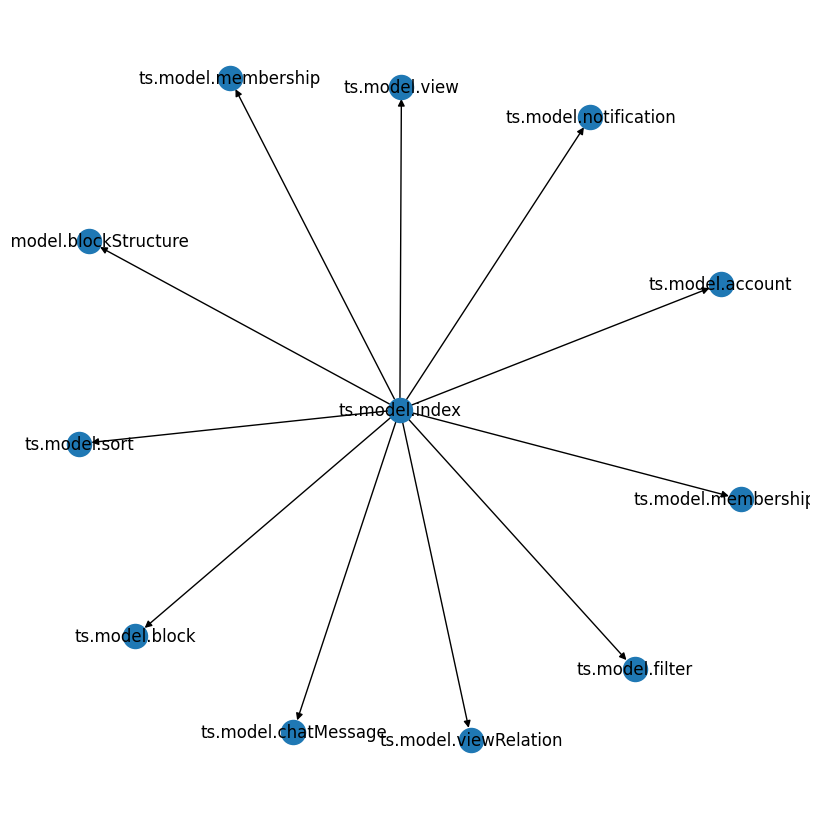

### ts.store.index dependancy tree
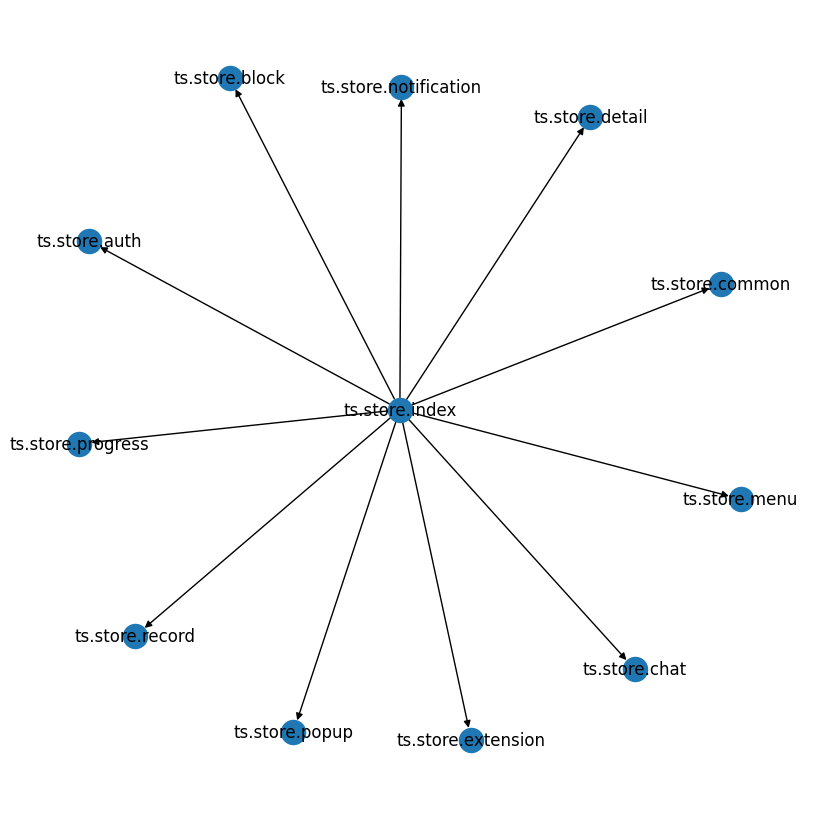

### ts.docs.index dependancy tree
Should obviuosly have been in the smaller dependancy trees category, but I made the picture and now I'll just use it. 
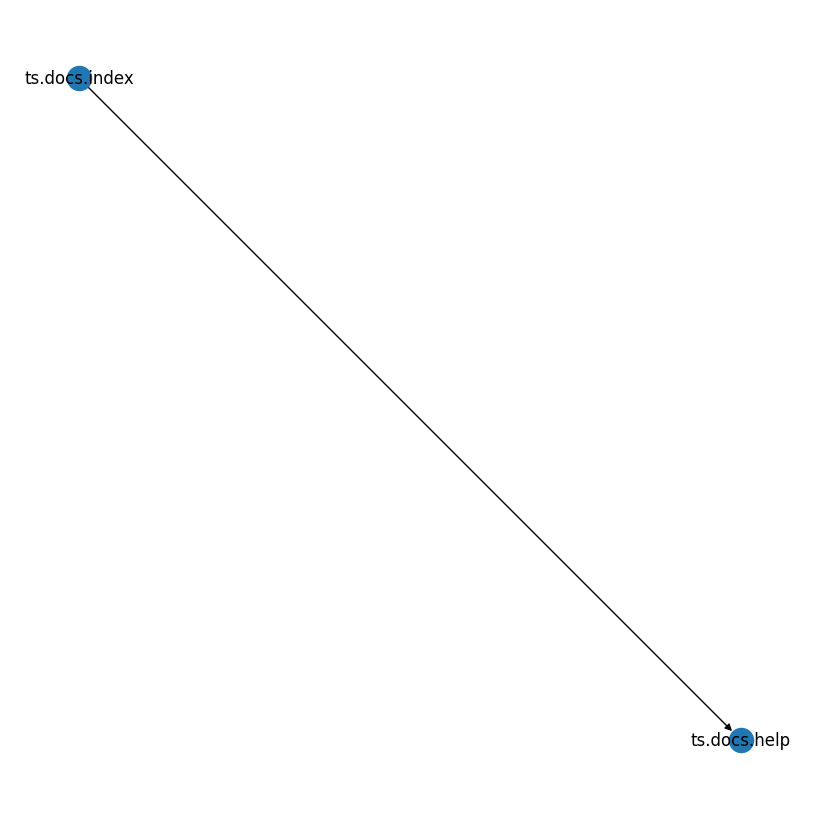

### ts.lib.index dependancy tree
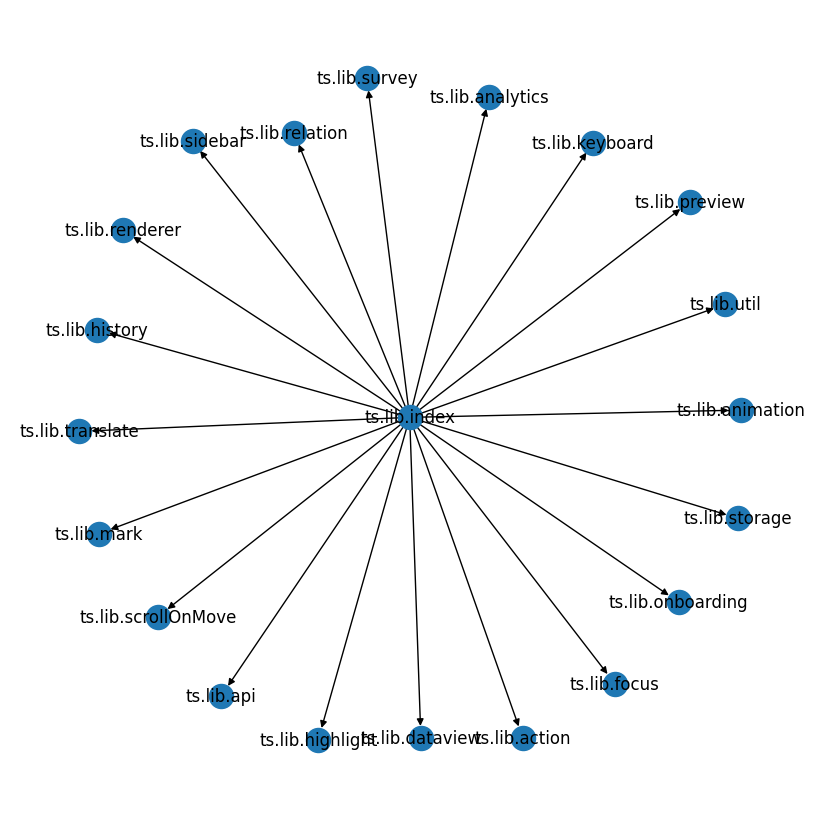

### ts.components.index dependancy tree
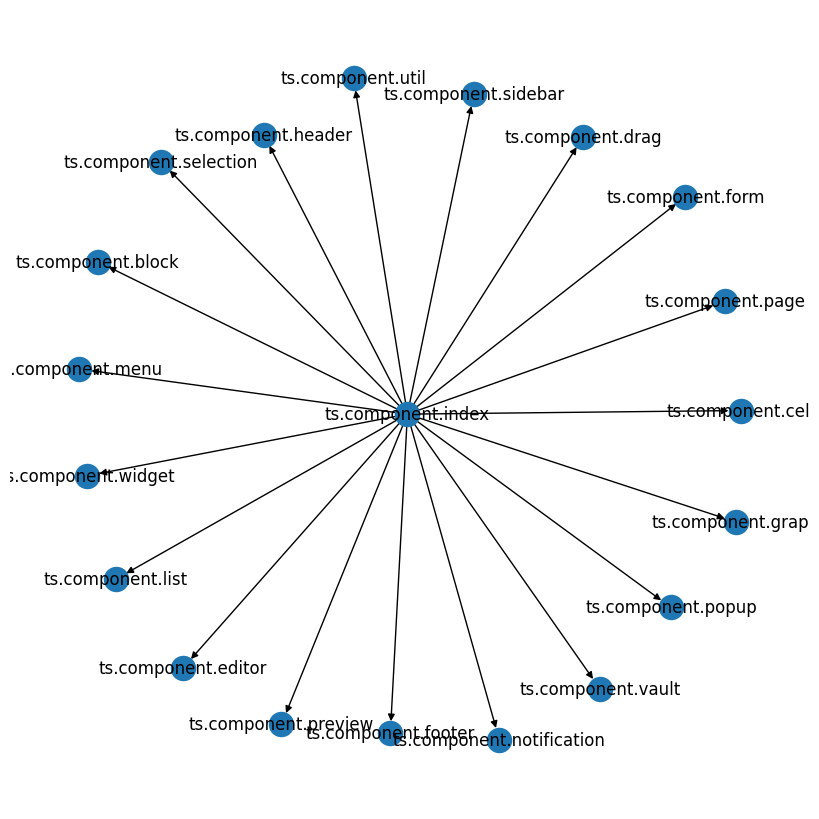

### json.index dependancy tree
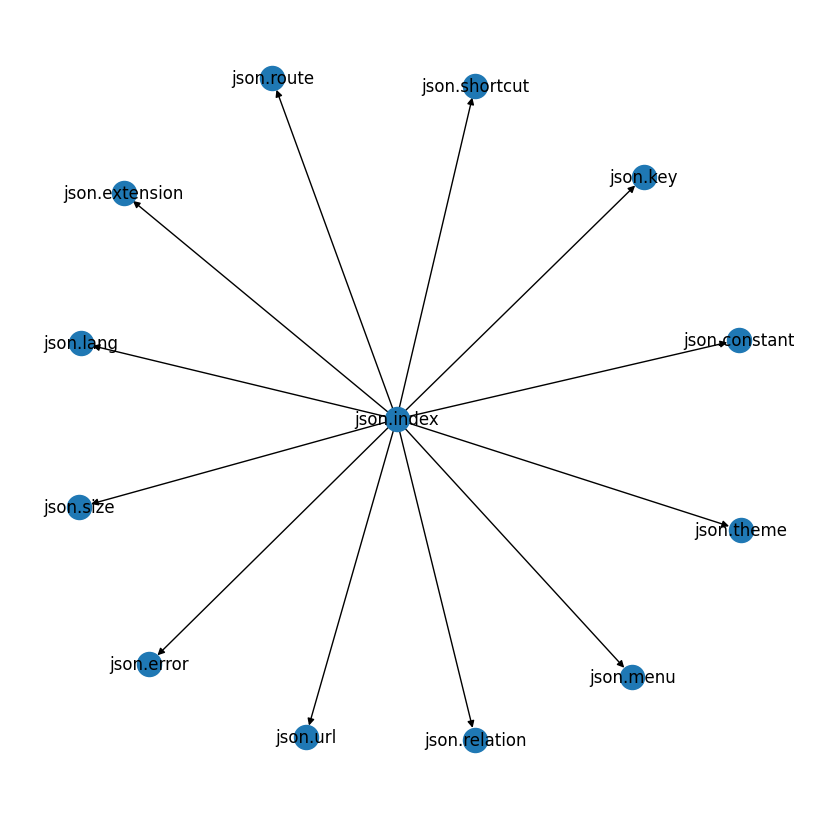

### Other smaller dependancies trees
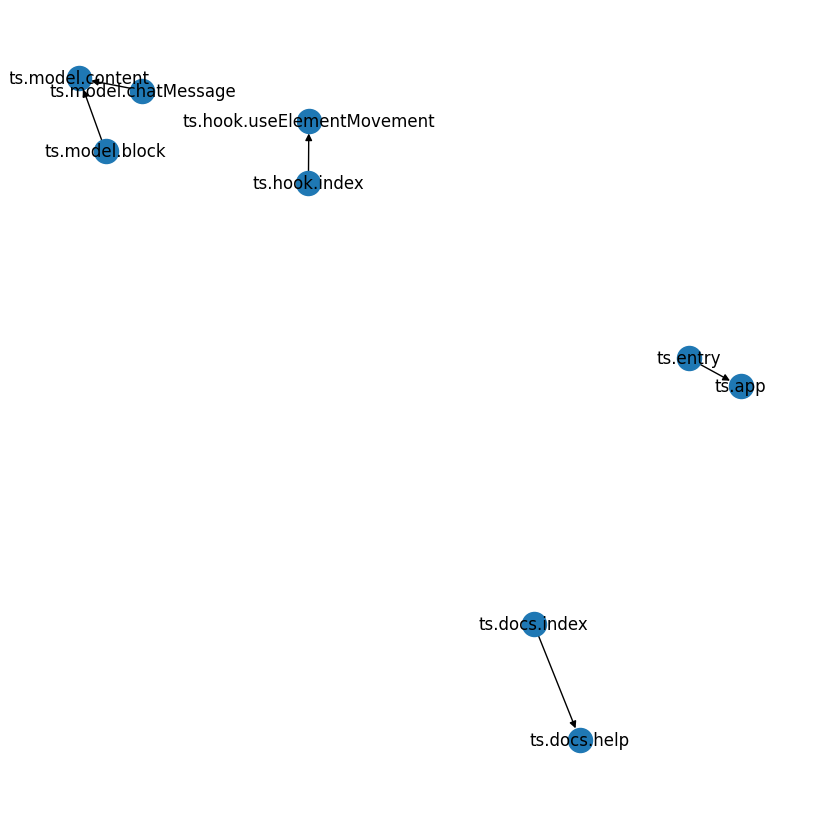

# Component focus

In [101]:
def abstracted_to_top_level_component(G, depth=1):
    aGC = nx.DiGraph()
    for each in G.edges():
          src = top_level_package(each[0], depth)
          dst = top_level_package(each[1], depth)

          if src != dst and src.startswith("src") and dst.startswith("src"):
              if "ts.component" in src or "ts.component" in dst:
                src = src.replace("src.", "")
                dst = dst.replace("src.", "")
                aGC.add_edge(src, dst)

    return aGC

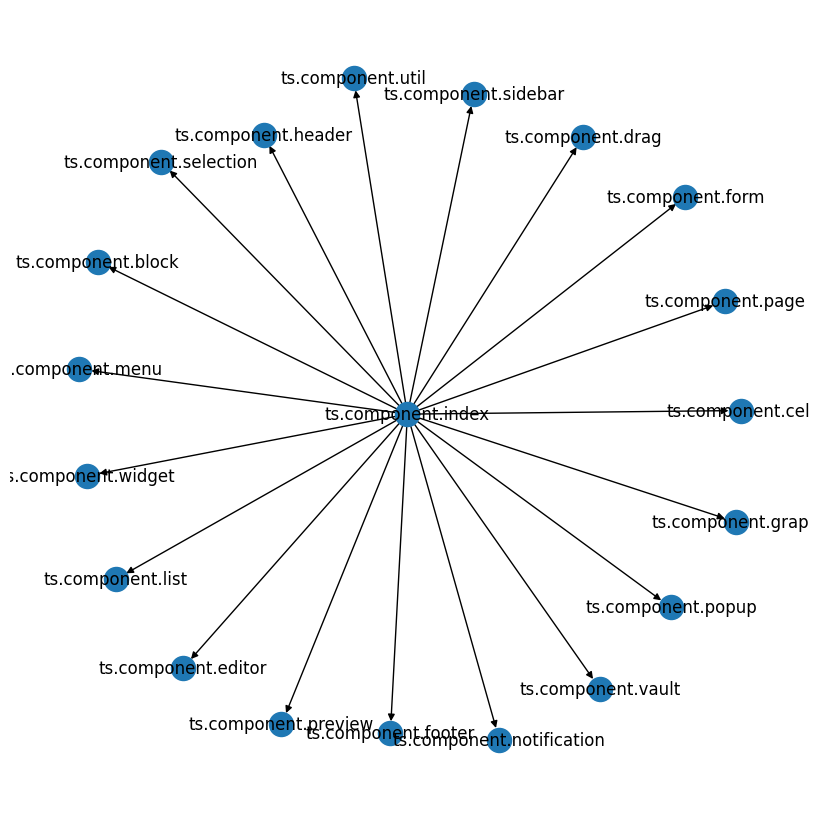

In [104]:
AHC = abstracted_to_top_level_component(H, 4)


draw_graph(AHC, (8,8), with_labels=True)
